<a href="https://colab.research.google.com/github/JueunL/IANNWTF-Group25/blob/Workflow/IANNWTF_HW9_jo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from numpy.random import randint
from time import perf_counter

## Generator

In [2]:
def generate_samples(n, len_seq, len_con):
  """ Generate samples for the "count occurences" excercise using a 
  generator.

  Args:
    n (int): Number of samples to generate
    len_seq (int): Length of the Sequence where the context numbers are counted
    len_con (int): Number of Context numbers

  Returns:
    (np.array): Array including the context numbers
    (np.array): Array including the sequence
    (np.array): Multi-Hot array showing which context number
                has the highest count in the sequence
                (if there are context numbers that share the highest count
                each will get a 1)
  """
  num = 0
  while num <= n:
    # Generate random sequence and context of specified lengths
    sequence = randint(0,10,len_seq)
    context = randint(0,10,len_con)

    # Count how many instances of each context word were in the sequence
    counts = [np.count_nonzero(sequence == c) for c in context]

    # Create a multi-hot encoded list where only the context number(s) with the
    # highest count are 1 (else 0)
    counts_max = np.max(counts)
    label = [int(c == counts_max) for c in counts]

    # Yield the result to turn the function into a generator which saves RAM
    #yield context, sequence, np.array(label)
    len_sample = len_seq + len_con
    yield np.concatenate((context, sequence)).reshape((len_sample, 1)), np.array(label).reshape((len_con, 1))

    num += 1

## LSTM

In [3]:
class LSTM_cell(layers.Layer):
  def __init__(self, len_t):
    super(LSTM_cell, self).__init__()

    self.len_t = len_t

    # Utility layers without weights
    self.concat = layers.Concatenate(axis=0)
    self.multiply = layers.Multiply()
    self.add = layers.Add()
    self.tanh = layers.Activation("tanh")

    self.forget_gate = layers.Dense(self.len_t, activation="sigmoid", bias_initializer="ones")
    self.input_gate = layers.Dense(self.len_t, activation="sigmoid")
    self.candidate_gate = layers.Dense(self.len_t, activation="tanh")
    self.output_gate = layers.Dense(self.len_t, activation="sigmoid")


  #@tf.function
  def call(self, x, h, cs):
    batch_size = tf.shape(x)[0]
    # Combine the current input and the hidden state
    h = self.concat([x,h])
    h = tf.reshape(h, (batch_size, 2))
    # Get the values of the forget gate and multiply the result with the cell state
    # to forget/partially forget unimportant values
    f = self.forget_gate(h)
    cs = self.multiply([cs, f])
    

    # Select important candidates and values from all candidates
    # Then add them and multiply the result with the cell state to get the
    # final cell state for this timestep
    i = self.input_gate(h)
    c = self.candidate_gate(h)
    cs = self.multiply([cs, self.add([i, c])])

    # Select which values from the hidden state should be output and 
    # multiply the result with the tanh normalised cell state to get 
    # the final hidden state of this timestep
    h = self.output_gate(h)
    h = self.multiply([h, self.tanh(cs)])

    return h, cs

In [4]:
class LSTM(tf.keras.Model):
  def __init__(self, len_con, len_seq, len_t):
    super(LSTM, self).__init__()

    self.x_len = len_con + len_seq
    
    self.cells = [LSTM_cell(len_t) for _ in range(self.x_len)]
    #self.cell = LSTM_cell(self.x_len)
    self.out = layers.Dense(len_con, "sigmoid")

  #@tf.function
  def call(self, x):
    batch_size = tf.shape(x)[0]
    # randomly initialize hidden and cell state (is apparently better than zeroes/ones)
    h = tf.random.uniform([batch_size,1], 0, 10, tf.float32)
    cs = tf.random.uniform([batch_size,1], 0, 10, tf.float32)
    for i in range(self.x_len):
      h, cs = self.cells[i](x[:,i], h, cs)
    #h, cs = self.cell(x, h, cs)
    h = self.out(h)
    return h



## Training

In [8]:
def acc_metric(target,output):
  # Check how many samples have the same prediction and target value and take the
  # mean which represents the accuracy
  acc = np.argmax(target, axis=1) == np.argmax(output, axis=1)
  acc = np.mean(acc)
 
  return acc

def train_step(model, input, target, loss_function, optimizer):
  # Train the model using gradient tape and return the loss for visualisation
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss 

def test(model, test_data, loss_function):
  # Get loss and accuracy of a dataset
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  acc_metric(target, prediction)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

def create_data(n, len_seq, len_con):
  # Generate a tensorflow dataset from the generator with a tensor for
  # context, sequence and label each
  generator = lambda: generate_samples(n, len_seq, len_con)
  data = tf.data.Dataset.from_generator(
      generator,
      output_signature=(
          tf.TensorSpec(shape=(len_seq + len_con,1), dtype=tf.float32),
          tf.TensorSpec(shape=(len_con,1), dtype=tf.float32)
      ))
  
  return data.batch(batch_size=BATCH_SIZE)

def train_model(num_epochs, data_train, data_test, learning_rate, model):
  tf.keras.backend.clear_session()

  running_average_factor = 0.95

  # Initialise the loss function for training
  # cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  train_losses, test_losses, test_accuracies = [],[],[]

  # Get the initial losses and the accuracy
  start = perf_counter()
  test_loss, test_accuracy = test(model, data_test, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  train_loss, _ = test(model, data_train, cross_entropy_loss)
  train_losses.append(train_loss)

  print((f"Init:" + " " *(len(str(num_epochs)) + 3) + " Accuracy: " + " " * (4 - len(str(round(test_accuracy * 100, 0)))) + f"{'{0:.3f}'.format(round(test_accuracy * 100, 3))}%,"
         f"  Loss: (Train: {'{0:.3f}'.format(round(float(train_losses[-1]), 3))},"
         f"  Test: {'{0:.3f}'.format(round(float(test_loss), 3))}),"
         f"  Overfitting Indicator: {'{0:+.3f}'.format(round(float(test_losses[-1] - train_losses[-1]), 3))},"
         f"  Time: {'{0:.2f}'.format(round(perf_counter() - start, 2))}s"))


  # TODO: What are these warnings??
  tf.get_logger().setLevel("ERROR")

  # Train the model (record the time as well for performance judgements)
  for epoch in range(1, num_epochs + 1):
      start = perf_counter()

      average = []
      for (input,target) in data_train:
          train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
          average.append(train_loss)
          
      train_losses.append(np.mean(average))
      
      test_loss, test_accuracy = test(model, data_test, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      print((f"Epoch #{epoch}:" + " " * (len(str(num_epochs)) - len(str(epoch))) +  f" Accuracy: {'{0:.3f}'.format(round(test_accuracy * 100, 3))}%,"
             f"  Loss: (Train: {'{0:.3f}'.format(round(float(train_losses[-1]), 3))},"
             f"  Test: {'{0:.3f}'.format(round(float(test_loss), 3))}),"
             f"  Overfitting Indicator: {'{0:+.3f}'.format(round(float(test_losses[-1] - train_losses[-1]), 3))},"
             f"  Time: {'{0:.2f}'.format(round(perf_counter() - start, 2))}s"))
      
  return train_losses, test_losses, test_accuracies

def plot_learning(train_losses, test_losses, test_accuracies, num_epochs):
  # draw the loss plot
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend((line1, line2), ("training", "test"))
  plt.show()

  # draw the accuracy plot
  line1, = plt.plot(test_accuracies)
  plt.xlabel("Epochs")
  plt.ylabel("Test-Accuracy")
  plt.show()

In [9]:
# Number of Context numbers
LEN_CONTEXT = 2 # @param

# Length of the Sequence where the context numbers are counted
LEN_SEQUENCE = 23 # @param

# Length of each timestep
LEN_T = 1 # @param

BATCH_SIZE =  64# @param

NUM_EPOCHS =  5# @param

TRAIN_SAMPLES = 64000# @param

TEST_SAMPLES = 6400# @param

LEARNING_RATE = 0.01# @param

Init:     Accuracy: 63.527%,  Loss: (Train: 0.874,  Test: 0.889),  Overfitting Indicator: +0.015,  Time: 12.38s
Epoch #1: Accuracy: 63.381%,  Loss: (Train: 0.880,  Test: 0.891),  Overfitting Indicator: +0.011,  Time: 23.44s
Epoch #2: Accuracy: 64.956%,  Loss: (Train: 0.882,  Test: 0.879),  Overfitting Indicator: -0.003,  Time: 23.34s
Epoch #3: Accuracy: 37.302%,  Loss: (Train: 0.882,  Test: 0.867),  Overfitting Indicator: -0.014,  Time: 23.45s
Epoch #4: Accuracy: 64.327%,  Loss: (Train: 0.881,  Test: 0.866),  Overfitting Indicator: -0.015,  Time: 23.28s
Epoch #5: Accuracy: 39.267%,  Loss: (Train: 0.883,  Test: 0.868),  Overfitting Indicator: -0.015,  Time: 23.47s


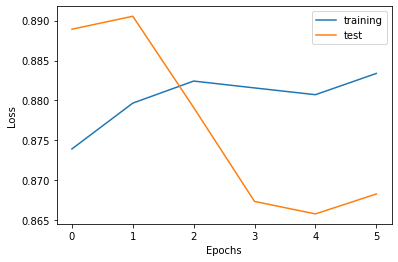

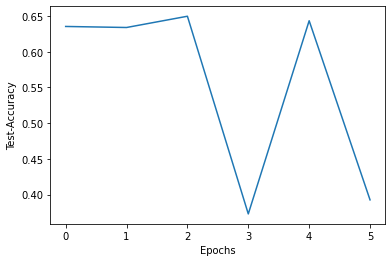

In [10]:
data_train = create_data(10000, LEN_SEQUENCE, LEN_CONTEXT)
data_test = create_data(1000, LEN_SEQUENCE, LEN_CONTEXT)

model = LSTM(LEN_CONTEXT, LEN_SEQUENCE, LEN_T)
trl, tel, tea = train_model(NUM_EPOCHS, data_train, data_test, LEARNING_RATE, model)
plot_learning(trl, tel, tea, NUM_EPOCHS)